In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IndustrialOcr.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
import os

unzipped_folder = "/content/IndustrialOcr"

for root, dirs, files in os.walk(unzipped_folder):
    #print(f"Folder: {root}")
    if dirs:
        print(f"Subfolders: {dirs}")

Subfolders: ['Test', 'Train']
Subfolders: ['BK21-64842-A-B', '23477043', 'D0CW-51301', 'D0CW-51310', '23305982', '23354374', '23301608', '23497667', 'D0CW-51300', '70085119-0300', '52611-0E110-A', '20871905']
Subfolders: ['BK21-64842-A-B', '23477043', 'D0CW-51301', 'D0CW-51310', '23305982', '23354374', '23301608', '23497667', 'D0CW-51300', '70085119-0300', '52611-0E110-A', '20871905']


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

In [ ]:
#Paths
minority_train_class_dir_1 = "/content/IndustrialOcr/Train/D0CW-51300"
minority_train_class_dir_2 = "/content/IndustrialOcr/Train/70085119-0300"


minority_train_class_dir_3 = "/content/IndustrialOcr/Train/20871905"
minority_train_class_dir_4 = "/content/IndustrialOcr/Train/BK21-64842-A-B"
minority_train_class_dir_5 = "/content/IndustrialOcr/Train/D0CW-51301"
minority_train_class_dir_6 = "/content/IndustrialOcr/Train/D0CW-51310"


minority_test_class_dir_1 = "/content/IndustrialOcr/Test/D0CW-51300"
minority_test_class_dir_2 = "/content/IndustrialOcr/Test/70085119-0300"


minority_test_class_dir_3 = "/content/IndustrialOcr/Test/20871905"
minority_test_class_dir_4 = "/content/IndustrialOcr/Test/BK21-64842-A-B"
minority_test_class_dir_5 = "/content/IndustrialOcr/Test/D0CW-51301"
minority_test_class_dir_6 = "/content/IndustrialOcr/Test/D0CW-51310"

#Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Augment to Upsample
def augment_images_in_directory(directory, prefix="aug_"):
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

    for i, image_file in enumerate(image_files):
        #Load
        img_path = os.path.join(directory, image_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)  #Expand to (1, h, w, channels)

        #Augmented images
        j = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=directory, save_prefix=prefix, save_format='jpeg'):
            j += 1
            if j >= 20:  #1 original image => 20 augmented images
                break  #Stop

# Augment images
augment_images_in_directory(minority_train_class_dir_1, prefix="aug_1_")
augment_images_in_directory(minority_train_class_dir_2, prefix="aug_2_")

augment_images_in_directory(minority_train_class_dir_3, prefix="aug_1_")
augment_images_in_directory(minority_train_class_dir_4, prefix="aug_2_")
augment_images_in_directory(minority_train_class_dir_5, prefix="aug_1_")
augment_images_in_directory(minority_train_class_dir_6, prefix="aug_2_")

augment_images_in_directory(minority_test_class_dir_1, prefix="aug_1_")
augment_images_in_directory(minority_test_class_dir_2, prefix="aug_2_")

augment_images_in_directory(minority_test_class_dir_3, prefix="aug_1_")
augment_images_in_directory(minority_test_class_dir_4, prefix="aug_2_")
augment_images_in_directory(minority_test_class_dir_5, prefix="aug_1_")
augment_images_in_directory(minority_test_class_dir_6, prefix="aug_2_")

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IndustrialOcrUpsample.zip", 'r')
os.makedirs("/content/IndustrialOcr", exist_ok=True)
zip_ref.extractall("/content/IndustrialOcr")
zip_ref.close()

In [4]:
#Paths
train_dir = '/content/IndustrialOcr/Train'
test_dir = '/content/IndustrialOcr/Test'

#The train and test generators
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
    #classes=desired_classes  # Only include these classes
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  #Reproduce Result
    #classes=desired_classes  # Only include these classes
)

Found 1511 images belonging to 12 classes.
Found 376 images belonging to 12 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

#Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Freeze
base_model.trainable = False

#Custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

#Build
model = Model(inputs=base_model.input, outputs=predictions)

#Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Train
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 16,
    epochs=25
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.7980 - loss: 0.6806
Epoch 2/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.9375 - loss: 0.1270  
Epoch 3/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


168/168 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.9527 - loss: 0.1311
Epoch 4/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 1.0000 - loss: 0.0441  
Epoch 5/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 61s 266ms/step - accuracy: 0.9558 - loss: 0.1138
Epoch 6/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 1.0000 - loss: 0.0097 
Epoch 7/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.9806 - loss: 0.0639
Epoch 8/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 1.0000 - loss: 0.0438 
Epoch 9/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.9784 - loss: 0.0725
Epoch 10/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 1.0000 - loss: 0.0177  
Epoch 11/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.9911 - loss: 0.0398
Epoch 12/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.9375 - loss: 0.0931 
Epoch 13/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9923 - loss: 0.0229
Epoch 14/25
168/168 ━━━━━━━━

In [ ]:
#Evaluate
loss, accuracy = model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.9848 - loss: 0.1205


In [ ]:
print(test_generator.class_indices)

{'20871905': 0, '23301608': 1, '23305982': 2, '23354374': 3, '23477043': 4, '23497667': 5, '52611-0E110-A': 6, '70085119-0300': 7, 'BK21-64842-A-B': 8, 'D0CW-51300': 9, 'D0CW-51301': 10, 'D0CW-51310': 11}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=450
batch_size=8
Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['20871905', '23301608', '23305982', '23354374', '23477043', '23497667', '52611-0E110-A', '70085119-0300', 'BK21-64842-A-B', 'D0CW-51300', 'D0CW-51301', 'D0CW-51310']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step
Confusion Matrix
[[ 21   0   0   0   0   0   0   0   0   0   0   0]
 [  0  82   0   0   2   0   0   0   0   0   0   0]
 [  0   0  20   0   0   0   0   0   0   0   0   0]
 [  0   0   0  64   0   0   0   0   0   0   0   0]
 [  0   2   0   0 118   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0   0   0   0]
 [  0   0   0   0   0   0  20   0   0   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0   0   0]
 [  0   0   0   0   0   0   0   2  19   0   0   0]
 [  0   0   0   0   0   0   0   0   0  37   5   0]
 [  0   0   0   0   0   0   0   0   0   5  37   0]
 [  0   0   0   0   0   0   0   0   0   0   1  41]]
Classification Report
                precision    recall  f1-score   support

      20871905       1.00      1.00      1.00        21
      23301608       0.98      0.98      0.98        84
      23305982       1.00      1.00      1.00        20
      23354374       1.00      1.00      1.00        64
      23477043       0.98

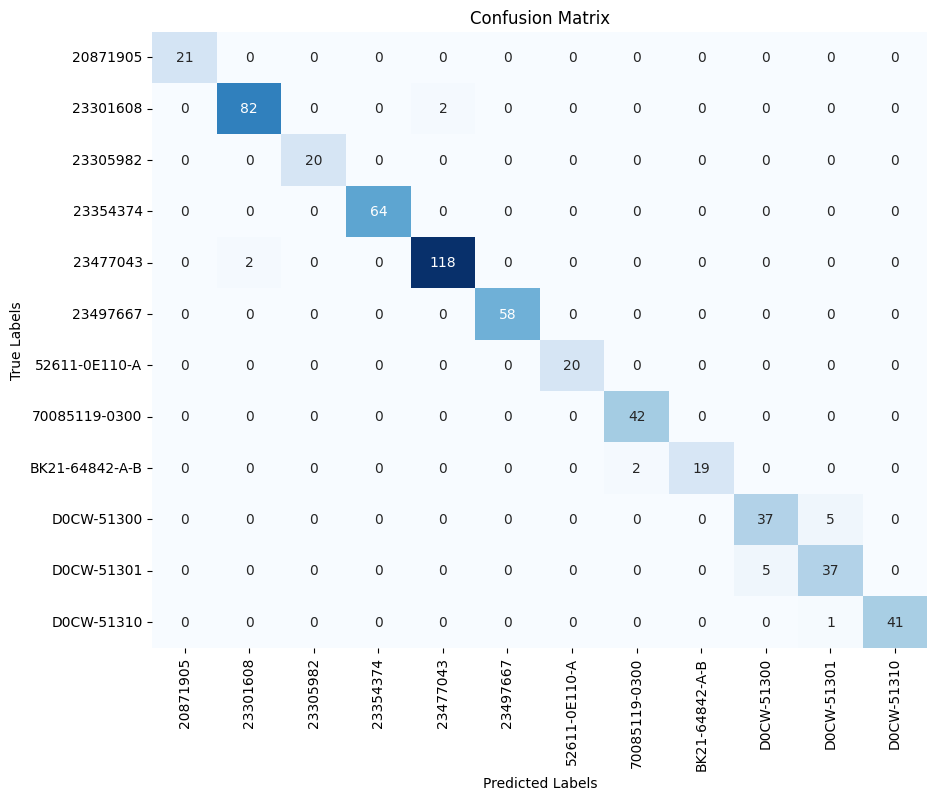

In [ ]:
# Define
target_names = ['20871905', '23301608', '23305982', '23354374', '23477043', '23497667', '52611-0E110-A', '70085119-0300', 'BK21-64842-A-B', 'D0CW-51300', 'D0CW-51301', 'D0CW-51310']

# Generate
confmat = confusion_matrix(test_generator.classes, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#weights_path = '/content/drive/MyDrive/MV Weight/Minority Class Upsampling/mv_minority_all_class.weights.h5'

#model.save_weights(weights_path)
model.load_weights('/content/drive/MyDrive/MV Weight/Minority Class Upsampling/mv_minority_all_class.weights.h5',skip_mismatch=True)

In [ ]:
# Define paths
base_folder = "/content/BalancedviaUpsampled"
train_folder = os.path.join(base_folder, "Train")
test_folder = os.path.join(base_folder, "Test")
zip_path = "/content/IndustrialOcrUpsample.zip"  # Zip file path
drive_path = "/content/drive/MyDrive/IndustrialOcrUpsample.zip"  # Destination in Google Drive

# Ensure the base folder exists
os.makedirs(base_folder, exist_ok=True)

# Move Train and Test into BalancedviaUpsampled
shutil.move("/content/IndustrialOcr/Train", train_folder)
shutil.move("/content/IndustrialOcr/Test", test_folder)

# Create a zip file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', base_folder)

# Move the zip file to Google Drive
shutil.move(zip_path, drive_path)

print("Zipping and upload to Google Drive completed successfully!")

Zipping and upload to Google Drive completed successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


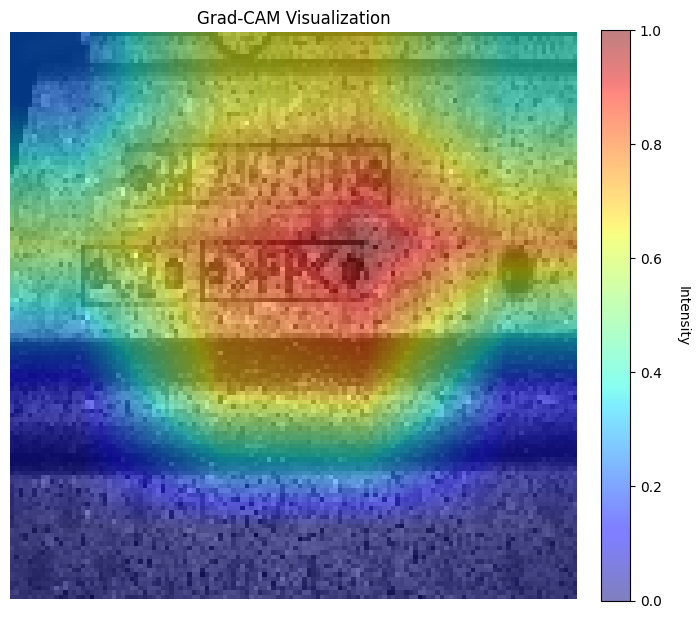

In [ ]:
img_path = "/content/IndustrialOcr/Train/23477043/23477043_358.jpg"  #Image path
image = load_img(img_path, target_size=(128, 128))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0  # Normalize

last_conv_layer = model.get_layer('Conv_1_bn')  #Layer name

#Create
grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

#Gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image_array)
    predicted_class = tf.argmax(predictions[0])
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize
heatmap = tf.image.resize(heatmap[..., np.newaxis], (image.size[1], image.size[0]))
heatmap = heatmap.numpy()
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Overlay
plt.figure(figsize=(8, 8))

#Original image
plt.imshow(image)

heatmap_plot = plt.imshow(heatmap[..., 0], cmap='jet', alpha=0.5)

cbar = plt.colorbar(heatmap_plot, fraction=0.046, pad=0.04)  #Size and position of the colorbar
cbar.set_label('Intensity', rotation=270, labelpad=20)

plt.axis('off')
plt.title("Grad-CAM Visualization")
plt.show()


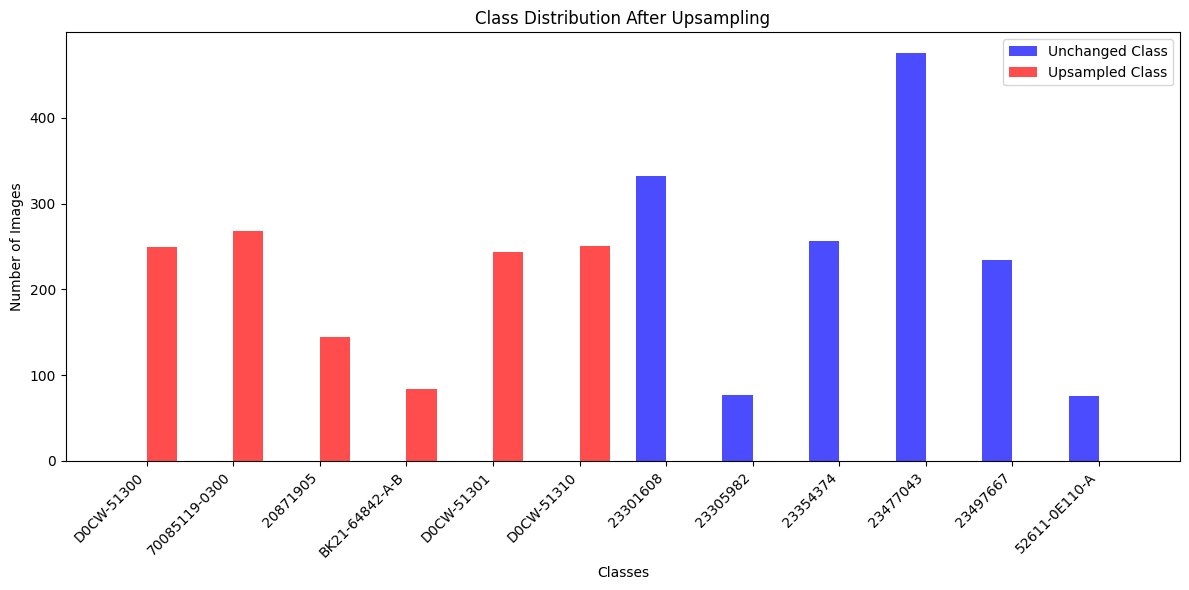

In [ ]:
#Define
upsampled_classes = [
    "D0CW-51300", "70085119-0300", "20871905",
    "BK21-64842-A-B", "D0CW-51301", "D0CW-51310"
]
unchanged_classes = [
    "23301608", "23305982", "23354374",
    "23477043", "23497667", "52611-0E110-A"
]
train_root = "/content/IndustrialOcr/Train"

#Combine
all_classes = upsampled_classes + unchanged_classes
class_counts_before = []
class_counts_after = []

for class_name in all_classes:
    class_path = os.path.join(train_root, class_name)
    if os.path.isdir(class_path):
        all_files = os.listdir(class_path)
        original_count = sum(1 for f in all_files if not f.startswith("aug"))
        augmented_count = sum(1 for f in all_files if f.startswith("aug"))

        if class_name in unchanged_classes:
            class_counts_before.append(original_count)
            class_counts_after.append(0)
        else:
            class_counts_before.append(0)
            class_counts_after.append(original_count + augmented_count)

# Plot
x = np.arange(len(all_classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))


bars1 = ax.bar(x - width/2, class_counts_before, width, label='Unchanged Class', color='blue', alpha=0.7)


bars2 = ax.bar(x + width/2, class_counts_after, width, label='Upsampled Class', color='red', alpha=0.7)

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution After Upsampling')
ax.set_xticks(x)
ax.set_xticklabels(all_classes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [6]:
# Extract class labels
class_labels = list(train_generator.class_indices.keys())

In [12]:
# Upload
from google.colab import files
def upload_image():
    uploaded = files.upload()  # Prompt user
    image_path = list(uploaded.keys())[0]
    return image_path

In [8]:
# Preprocess
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [9]:
def predict(image_path):
    processed_img = preprocess_image(image_path)
    predictions = model.predict(processed_img)[0]
    predicted_class_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_class_index]
    confidence = predictions[predicted_class_index] * 100

    non_zero_confidences = [
        f"{class_labels[i]}: {predictions[i] * 100:.2f}%"
        for i in range(len(class_labels))
        if i != predicted_class_index and predictions[i] > 0
    ]


    other_confidences = ", ".join(non_zero_confidences)

    return predicted_label, confidence, other_confidences

In [10]:
def display_prediction(image_path, predicted_label, confidence, other_confidences):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()


    print(f"Predicted Serial Number: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%")

Please upload an image for prediction:


Saving 52611-0E110-A_1166.jpg to 52611-0E110-A_1166 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


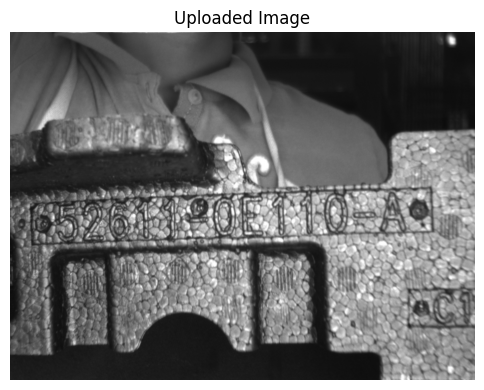

Predicted Serial Number: 52611-0E110-A
Confidence: 99.99%


In [17]:
if __name__ == "__main__":
    print("Please upload an image for prediction:")
    image_path = upload_image()  # Upload an image in Colab
    if image_path:
        predicted_label, confidence, other_confidences = predict(image_path)
        display_prediction(image_path, predicted_label, confidence, other_confidences)
    else:
        print("No image uploaded.")